In [1]:
# import libraries

import pandas as pd 
# pd.set_option('display.max_columns', None)
# pd.set_option('display.max_rows', None)
import numpy as np 
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler, normalize, scale
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.decomposition import PCA
from sklearn.metrics import mean_squared_error, r2_score

import requests 
import time
from bs4 import BeautifulSoup
from urllib.request import urlopen
import json # If reading in data from Json file
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe
import folium # maps
from geopy.geocoders import Nominatim # uses address to get lat/long

# Installations
#!conda install -c conda-forge geopy 
#!conda install -c conda-forge folium=0.5.0 

#  Obtain Data

#### Scrape Wikipedia for Location of Cities in the California Bay Area

In [2]:
# Obtain location data from Wikipedia
# https://stackoverflow.com/questions/54890708/scraping-data-from-wikipedia-table

url= 'https://en.wikipedia.org/wiki/List_of_cities_and_towns_in_the_San_Francisco_Bay_Area'  
df=pd.read_html(url, header=1)[0]

df.head()

,Name,Type,County,Population (2010)[8][9],sq mi,km2,Incorporated[7]
0,Alameda,City,Alameda,73812,10.61,27.5,"April 19, 1854"
1,Albany,City,Alameda,18539,1.79,4.6,"September 22, 1908"
2,American Canyon,City,Napa,19454,4.84,12.5,"January 1, 1992"
3,Antioch,City,Contra Costa,102372,28.35,73.4,"February 6, 1872"
4,Atherton,Town,San Mateo,6914,5.02,13.0,"September 12, 1923"


#### Explore Data

In [3]:
# View datatypes
df.dtypes

Name                        object
Type                        object
County                      object
Population (2010)[8][9]      int64
sq mi                      float64
km2                        float64
Incorporated[7]             object
dtype: object

In [4]:
# Check for nulls
df.isnull().sum()

Name                       0
Type                       0
County                     0
Population (2010)[8][9]    0
sq mi                      0
km2                        0
Incorporated[7]            0
dtype: int64

In [5]:
# View shape
df.shape

(101, 7)

In [6]:
# Rename columns

df.rename(columns={
    'Population (2010)[8][9]': 'population',
    'Incorporated[7]': 'incorporated',
    'Name': 'city/town'
}, inplace=True)

In [7]:
# Confirm name changes
df.head(1)

,city/town,Type,County,population,sq mi,km2,incorporated
0,Alameda,City,Alameda,73812,10.61,27.5,"April 19, 1854"


In [8]:
# Format column names
df.columns = [c.replace(' ', '_').lower() for c in df.columns]
df.head()

,city/town,type,county,population,sq_mi,km2,incorporated
0,Alameda,City,Alameda,73812,10.61,27.5,"April 19, 1854"
1,Albany,City,Alameda,18539,1.79,4.6,"September 22, 1908"
2,American Canyon,City,Napa,19454,4.84,12.5,"January 1, 1992"
3,Antioch,City,Contra Costa,102372,28.35,73.4,"February 6, 1872"
4,Atherton,Town,San Mateo,6914,5.02,13.0,"September 12, 1923"


In [9]:
df.head()

,city/town,type,county,population,sq_mi,km2,incorporated
0,Alameda,City,Alameda,73812,10.61,27.5,"April 19, 1854"
1,Albany,City,Alameda,18539,1.79,4.6,"September 22, 1908"
2,American Canyon,City,Napa,19454,4.84,12.5,"January 1, 1992"
3,Antioch,City,Contra Costa,102372,28.35,73.4,"February 6, 1872"
4,Atherton,Town,San Mateo,6914,5.02,13.0,"September 12, 1923"


In [10]:
# Add Stanford and Alviso to match the sales data
new_row_1 = {'city/town': 'Stanford', 'county': 'Santa Clara'}
new_row_2 = {'city/town': 'Alviso', 'county': 'Santa Clara'}

#append row to the dataframe
df = df.append(new_row_1, ignore_index=True)
df = df.append(new_row_2, ignore_index=True)

# Obtain Lat/Long Data

In [11]:
# address = 'Santa Clara, California'

# geolocator = Nominatim(user_agent = "foursquare_agent")
# location = geolocator.geocode(address)
# latitude = location.latitude
# longitude = location.longitude
# print('The geograpical coordinate of {} are {}, {}.'.format(address, latitude, longitude))

In [12]:
# for name in df['name']:
#     address = name + ', California'
#     print(address)

In [13]:
# Look up lat/long with geopy library

lats = []
longs = []
    
for name in df['city/town']:
    address = name + ', California'
    geolocator = Nominatim(user_agent = "foursquare_agent")
    location = geolocator.geocode(address)
    latitude = location.latitude
    longitude = location.longitude
    lats.append(latitude)
    longs.append(longitude)

In [14]:
# Populate df with lat/long

df['latitude'] = lats
df['longitude'] = longs
df.tail()

,city/town,type,county,population,sq_mi,km2,incorporated,latitude,longitude
98,Windsor,Town,Sonoma,26801.0,7.27,18.8,"July 1, 1992",38.547133,-122.816380
99,Woodside,Town,San Mateo,5287.0,11.73,30.4,"November 16, 1956",37.429939,-122.253856
100,Yountville,Town,Napa,2933.0,1.53,4.0,"February 4, 1965",38.402201,-122.359506
101,Stanford,NaN,Santa Clara,NaN,NaN,NaN,NaN,37.427467,-122.170244
102,Alviso,NaN,Santa Clara,NaN,NaN,NaN,NaN,37.426051,-121.975237


In [15]:
# Locate county with enough cities to compare (Looking for ~10-15)

df['county'].value_counts()

San Mateo        20
Contra Costa     19
Santa Clara      17
Alameda          14
Marin            11
Sonoma            9
Solano            7
Napa              5
San Francisco     1
Name: county, dtype: int64

In [16]:
# View cities in Santa Clara County

df[df['county']=='Santa Clara']

,city/town,type,county,population,sq_mi,km2,incorporated,latitude,longitude
13,Campbell,City,Santa Clara,39349.0,5.80,15.0,"March 28, 1952",37.287063,-121.944882
20,Cupertino,City,Santa Clara,58302.0,11.26,29.2,"October 10, 1955",37.322893,-122.032290
32,Gilroy,City,Santa Clara,48821.0,16.15,41.8,"March 12, 1870",37.006508,-121.563172
41,Los Altos,City,Santa Clara,28976.0,6.49,16.8,"December 1, 1952",37.379063,-122.116578
42,Los Altos Hills,Town,Santa Clara,7922.0,8.80,22.8,"January 27, 1956",37.379663,-122.137464
43,Los Gatos,Town,Santa Clara,29413.0,11.08,28.7,"August 10, 1887",37.226611,-121.974680
48,Milpitas,City,Santa Clara,66790.0,13.59,35.2,"January 26, 1954",37.428272,-121.906624
49,Monte Sereno,City,Santa Clara,3341.0,1.62,4.2,"May 14, 1957",37.236333,-121.992458
51,Morgan Hill,City,Santa Clara,37882.0,12.88,33.4,"November 10, 1906",37.130408,-121.654497
52,Mountain View,City,Santa Clara,74066.0,12.00,31.1,"November 7, 1902",37.389389,-122.083210


In [17]:
# Create new df for Santa Clara County and reset index

sclara = df[df['county'] == 'Santa Clara'].reset_index(drop=True)
sclara.head(13)

,city/town,type,county,population,sq_mi,km2,incorporated,latitude,longitude
0,Campbell,City,Santa Clara,39349.0,5.80,15.0,"March 28, 1952",37.287063,-121.944882
1,Cupertino,City,Santa Clara,58302.0,11.26,29.2,"October 10, 1955",37.322893,-122.032290
2,Gilroy,City,Santa Clara,48821.0,16.15,41.8,"March 12, 1870",37.006508,-121.563172
3,Los Altos,City,Santa Clara,28976.0,6.49,16.8,"December 1, 1952",37.379063,-122.116578
4,Los Altos Hills,Town,Santa Clara,7922.0,8.80,22.8,"January 27, 1956",37.379663,-122.137464
5,Los Gatos,Town,Santa Clara,29413.0,11.08,28.7,"August 10, 1887",37.226611,-121.974680
6,Milpitas,City,Santa Clara,66790.0,13.59,35.2,"January 26, 1954",37.428272,-121.906624
7,Monte Sereno,City,Santa Clara,3341.0,1.62,4.2,"May 14, 1957",37.236333,-121.992458
8,Morgan Hill,City,Santa Clara,37882.0,12.88,33.4,"November 10, 1906",37.130408,-121.654497
9,Mountain View,City,Santa Clara,74066.0,12.00,31.1,"November 7, 1902",37.389389,-122.083210


In [18]:
# Fix lat/long for Santa Clara

sclara.loc[12,'latitude'] = 37.352483
sclara.loc[12,'longitude'] = -121.956564

# Confirm change
sclara.loc[sclara['city/town'] == 'Santa Clara']

,city/town,type,county,population,sq_mi,km2,incorporated,latitude,longitude
12,Santa Clara,City,Santa Clara,116468.0,18.41,47.7,"July 5, 1852",37.352483,-121.956564


#### Sales Data

In [19]:
# Read in home sales data
sales = pd.read_csv('../data/santa_clara_co_sales_2019.csv')
sales.head()

,city/town,average_price,median_price
0,Alviso,"$888,000.00","$888,000.00"
1,NaN,NaN,NaN
2,Campbell,"$1,482,331.00","$1,385,000.00"
3,NaN,NaN,NaN
4,Cupertino,"$2,303,351.00","$2,250,000.00"


In [20]:
# Drop nulls
sales.dropna(subset=["city/town"], axis=0, inplace=True)
sales

,city/town,average_price,median_price
0,Alviso,"$888,000.00","$888,000.00"
2,Campbell,"$1,482,331.00","$1,385,000.00"
4,Cupertino,"$2,303,351.00","$2,250,000.00"
6,Gilroy,"$863,170.00","$781,000.00"
8,Los Altos,"$3,481,950.00","$3,288,000.00"
10,Los Altos Hills,"$4,498,349.00","$4,200,000.00"
12,Los Gatos,"$2,340,757.00","$2,185,000.00"
14,Milpitas,"$1,133,620.00","$1,090,000.00"
16,Monte Sereno,"$3,349,917.00","$3,125,000.00"
18,Morgan Hill,"$1,125,291.00","$1,025,000.00"


In [21]:
# View dtypes

sales.dtypes

city/town        object
average_price    object
median_price     object
dtype: object

In [22]:
# Format data

sales['average_price'] = [item.replace('$','').replace(',','') for item in sales['average_price']]
sales.head()

,city/town,average_price,median_price
0,Alviso,888000.00,"$888,000.00"
2,Campbell,1482331.00,"$1,385,000.00"
4,Cupertino,2303351.00,"$2,250,000.00"
6,Gilroy,863170.00,"$781,000.00"
8,Los Altos,3481950.00,"$3,288,000.00"


In [23]:
# Format data
sales['median_price'] = [item.replace('$','').replace(',','') for item in sales['median_price']]
sales.head()

,city/town,average_price,median_price
0,Alviso,888000.00,888000.00
2,Campbell,1482331.00,1385000.00
4,Cupertino,2303351.00,2250000.00
6,Gilroy,863170.00,781000.00
8,Los Altos,3481950.00,3288000.00


In [24]:
# Convert dtype to float

sales['average_price'] = sales['average_price'].astype(float)

In [25]:
# Convert dtype to float

sales['median_price'] = sales['median_price'].astype(float)

In [26]:
# Confirm dtype conversion

sales.dtypes

city/town         object
average_price    float64
median_price     float64
dtype: object

In [27]:
# Reset index

sales = sales.reset_index()
sales.head()

,index,city/town,average_price,median_price
0,0,Alviso,888000.0,888000.0
1,2,Campbell,1482331.0,1385000.0
2,4,Cupertino,2303351.0,2250000.0
3,6,Gilroy,863170.0,781000.0
4,8,Los Altos,3481950.0,3288000.0


In [28]:
# Drop old index

sales = sales.drop(['index'], axis=1)
sales.head()

,city/town,average_price,median_price
0,Alviso,888000.0,888000.0
1,Campbell,1482331.0,1385000.0
2,Cupertino,2303351.0,2250000.0
3,Gilroy,863170.0,781000.0
4,Los Altos,3481950.0,3288000.0


In [29]:
# Strip spaces from names in sales df

sales['city/town']=sales['city/town'].str.strip()
sales['city/town'].tolist()

['Alviso',
 'Campbell',
 'Cupertino',
 'Gilroy',
 'Los Altos',
 'Los Altos Hills',
 'Los Gatos',
 'Milpitas',
 'Monte Sereno',
 'Morgan Hill',
 'Mountain View',
 'Palo Alto',
 'San Jose',
 'San Martin',
 'Santa Clara',
 'Saratoga',
 'Stanford',
 'Sunnyvale']

In [30]:
# Merge location and sales dataframes

df = pd.concat([sclara.set_index('city/town'), sales.set_index('city/town')], axis=1, join='inner')
df.reset_index(inplace=True)
df.head()

,city/town,type,county,population,sq_mi,km2,incorporated,latitude,longitude,average_price,median_price
0,Campbell,City,Santa Clara,39349.0,5.80,15.0,"March 28, 1952",37.287063,-121.944882,1482331.0,1385000.0
1,Cupertino,City,Santa Clara,58302.0,11.26,29.2,"October 10, 1955",37.322893,-122.032290,2303351.0,2250000.0
2,Gilroy,City,Santa Clara,48821.0,16.15,41.8,"March 12, 1870",37.006508,-121.563172,863170.0,781000.0
3,Los Altos,City,Santa Clara,28976.0,6.49,16.8,"December 1, 1952",37.379063,-122.116578,3481950.0,3288000.0
4,Los Altos Hills,Town,Santa Clara,7922.0,8.80,22.8,"January 27, 1956",37.379663,-122.137464,4498349.0,4200000.0


In [31]:
df.columns.tolist()

['city/town',
 'type',
 'county',
 'population',
 'sq_mi',
 'km2',
 'incorporated',
 'latitude',
 'longitude',
 'average_price',
 'median_price']

# Visualize

In [32]:
# Get index for City of Santa Clara for map

df[df['city/town']=='Santa Clara']

,city/town,type,county,population,sq_mi,km2,incorporated,latitude,longitude,average_price,median_price
12,Santa Clara,City,Santa Clara,116468.0,18.41,47.7,"July 5, 1852",37.352483,-121.956564,1385798.0,1357500.0


In [33]:
# create map of the cities in Santa Clara County with the city of Santa Clara as the focal point
map_df = folium.Map(location=[df.iloc[12,7], df.iloc[12,8]], zoom_start=10)

# add markers to map
for lat, lng, name, county in zip(df['latitude'], df['longitude'], df['city/town'], df['county']):
    label = '{}, {} County'.format(name, county)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='purple',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.6,
        parse_html=False).add_to(map_df)  
    
map_df

## Foursquare Data

In [34]:
# Establish Foursquare credentials for reference

CLIENT_ID = 'S5JB2KFD1NTX3EQLZEUCB5OLMPQTFOITAQG1ZMHVNB12UFH0' 
CLIENT_SECRET = '2SV2BAJSKBTEXPH41FHT2X3P1M1VQKYLZ54213I0VAZU2JPT' 
VERSION = '20200609' # Foursquare API version


In [35]:
# df.loc[0, 'city/town']

In [36]:
# city_latitude = df.loc[0, 'latitude']
# city_longitude = df.loc[0, 'longitude'] 

# city_name = df.loc[0, 'city/town'] 

# print('Latitude and longitude values of {} are {}, {}.'.format(city_name, 
#                                                                city_latitude, 
#                                                                city_longitude))

In [37]:
# #Foursquare rate limits: https://developer.foursquare.com/docs/places-api/rate-limits/
    
# LIMIT = 100 # limit of number of venues returned by Foursquare API

# radius = 500 # define radius

# # create URL
# url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
#     CLIENT_ID, 
#     CLIENT_SECRET, 
#     VERSION, 
#     city_latitude, 
#     city_longitude, 
#     radius, 
#     LIMIT)

In [38]:
# results = requests.get(url).json()

In [39]:
# # function that extracts the category of the venue
# def get_category_type(row):
#     try:
#         categories_list = row['categories']
#     except:
#         categories_list = row['venue.categories']
        
#     if len(categories_list) == 0:
#         return None
#     else:
#         return categories_list[0]['name']

In [40]:
# venues = results['response']['groups'][0]['items']
    
# nearby_venues = json_normalize(venues) # flatten JSON

# # filter columns
# filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
# nearby_venues =nearby_venues.loc[:, filtered_columns]

# # filter the category for each row
# nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis=1)

# # clean columns
# nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]

# nearby_venues.head()

In [41]:
# # Campbell only
# print('{} venues returned from Foursquare'.format(nearby_venues.shape[0]))

In [42]:
# df['city/town'].unique()

In [43]:
# Collect venue results from Foursquare
# Code adapted from IBM data science cert lab

radius = 1000 # 
limit = 200

venues = []

for lat, long, city in zip(df['latitude'], df['longitude'], df['city/town']):
    url = "https://api.foursquare.com/v2/venues/explore?client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}".format(
        CLIENT_ID,
        CLIENT_SECRET,
        VERSION,
        lat,
        long,
        radius, 
        limit)
    
    results = requests.get(url).json()["response"]['groups'][0]['items']
    
    for venue in results:
        venues.append((
            city,
            lat, 
            long, 
            venue['venue']['name'], 
            venue['venue']['location']['lat'], 
            venue['venue']['location']['lng'],  
            venue['venue']['categories'][0]['name']))

KeyError: 'groups'

In [ ]:
#  venues into a dataframe
venues_df = pd.DataFrame(venues)
venues_df.columns = ['city/town', 'latitude', 'longitude', 'venue_name', 'venue_latitude', 'venue_longitude', 'venue_type']

# check the dataframe
print('Shape: {}'.format(venues_df.shape))
print('Unique venue types: {}'.format(len(venues_df['venue_type'].unique())))
venues_df.head()

In [ ]:
# # Collect venue results from Foursquare
# # Code adapted from IBM data science cert lab

# radius = 1000 
# limit = 200

# for lat, long, city in zip(df['latitude'], df['longitude'], df['city/town']):
#     url = "https://api.foursquare.com/v2/venues/explore?client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}".format(
#         CLIENT_ID,
#         CLIENT_SECRET,
#         VERSION,
#         lat,
#         long,
#         radius, 
#         limit)
    
#     results = requests.get(url).json()['response']['groups'][0]['items']
    
#     venues = []

#     for venue in results:
#         venues.append((
#             city,
#             lat, 
#             long, 
#             venue['venue']['name'], 
#             venue['venue']['location']['lat'], 
#             venue['venue']['location']['lng'],  
#             venue['venue']['categories'][0]['name']))

In [ ]:
venues_df.to_csv('../data/venues_df.csv', index=False)

In [44]:
venues_df = pd.read_csv('../data/venues_df.csv')
venues_df.head()

,city/town,latitude,longitude,venue_name,venue_latitude,venue_longitude,venue_type
0,Campbell,37.287063,-121.944882,Manresa Bread,37.287099,-121.946670,Bakery
1,Campbell,37.287063,-121.944882,Therapy,37.287187,-121.943864,Boutique
2,Campbell,37.287063,-121.944882,Blue Line Pizza,37.287142,-121.942620,Pizza Place
3,Campbell,37.287063,-121.944882,The Vesper,37.286963,-121.942951,Cocktail Bar
4,Campbell,37.287063,-121.944882,Campbell Farmers' Market,37.287102,-121.945564,Farmers Market


In [45]:
venues_df['city/town'].unique()

array(['Campbell', 'Cupertino', 'Gilroy', 'Los Altos', 'Los Altos Hills',
       'Los Gatos', 'Milpitas', 'Monte Sereno', 'Morgan Hill',
       'Mountain View', 'Palo Alto', 'San Jose', 'Santa Clara',
       'Saratoga', 'Sunnyvale', 'Stanford', 'Alviso'], dtype=object)

In [ ]:
# Create function to generate venues for all cities in Santa Clara County

# def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
#     venues_list=[]
#     for name, lat, lng in zip(names, latitudes, longitudes):
#         print(name)
            
#         # create the API request URL
#         url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
#             CLIENT_ID, 
#             CLIENT_SECRET, 
#             VERSION, 
#             lat, 
#             lng, 
#             radius, 
#             LIMIT)
            
#         # make the GET request
#         results = requests.get(url).json()["response"]['groups'][0]['items']
        
#         # return only relevant information for each nearby venue
#         venues_list.append([(
#             name, 
#             lat, 
#             lng, 
#             v['venue']['name'], 
#             v['venue']['location']['lat'], 
#             v['venue']['location']['lng'],  
#             v['venue']['categories'][0]['name']) for v in results])

#     nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
#     nearby_venues.columns = ['city/town', 
#                   'City Latitude', 
#                   'City Longitude', 
#                   'Venue', 
#                   'Venue Latitude', 
#                   'Venue Longitude', 
#                   'Venue Category']
    
#     return(nearby_venues)

In [ ]:
# scc is for santa clara county
# scc_venues = getNearbyVenues(names=df['city/town'],
#                                    latitudes=df['latitude'],
#                                    longitudes=df['longitude']
#                                   )


In [46]:
# Count of venues per city
venues_df.groupby('city/town').count()

,latitude,longitude,venue_name,venue_latitude,venue_longitude,venue_type
city/town,,,,,,
Alviso,19,19,19,19,19,19
Campbell,100,100,100,100,100,100
Cupertino,82,82,82,82,82,82
Gilroy,72,72,72,72,72,72
Los Altos,68,68,68,68,68,68
Los Altos Hills,6,6,6,6,6,6
Los Gatos,100,100,100,100,100,100
Milpitas,95,95,95,95,95,95
Monte Sereno,6,6,6,6,6,6


In [47]:
# one hot encoding
df_onehot = pd.get_dummies(venues_df[['venue_type']], prefix="", prefix_sep="")

# Add city/town to venue df
df_onehot['city/town'] = venues_df['city/town'] 

# move city/town column to the first column
fixed_columns = [df_onehot.columns[-1]] + list(df_onehot.columns[:-1])
df_onehot = df_onehot[fixed_columns]

df_onehot.head()

,city/town,ATM,Afghan Restaurant,American Restaurant,Arcade,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,...,Used Bookstore,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Warehouse Store,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio
0,Campbell,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Campbell,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Campbell,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Campbell,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,Campbell,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [48]:
# new shape
df_onehot.shape

(1149, 230)

In [49]:
# Group venue type count by city

df_grouped = df_onehot.groupby('city/town').sum().reset_index() 
df_grouped

,city/town,ATM,Afghan Restaurant,American Restaurant,Arcade,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,...,Used Bookstore,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Warehouse Store,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio
0,Alviso,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Campbell,0,0,2,1,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,2
2,Cupertino,0,0,1,0,0,0,0,1,0,...,0,0,1,2,0,0,0,0,0,1
3,Gilroy,0,0,2,0,0,0,0,1,0,...,0,0,1,0,1,1,0,1,0,0
4,Los Altos,1,0,3,1,0,0,0,0,1,...,0,0,0,0,0,1,0,0,0,1
5,Los Altos Hills,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,Los Gatos,0,0,2,0,0,0,0,1,0,...,0,0,0,1,0,1,1,0,1,0
7,Milpitas,0,1,0,0,0,0,0,3,0,...,0,0,0,5,0,0,0,1,0,0
8,Monte Sereno,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9,Morgan Hill,0,0,3,0,0,0,0,1,0,...,0,0,0,3,0,1,0,0,0,0


In [50]:
# View size
df_grouped.shape

(17, 230)

In [ ]:
# # Boxplots

# plt.figure(figsize=(20, 10))
# plt.xticks(rotation='vertical')
# sns.boxplot

# ax = sns.boxplot(data = df_grouped)
# ax.set_ylabel('Venue Count', fontsize=25)
# ax.set_xlabel('Venue Type', fontsize=25)
# ax.tick_params(labelsize=20)
# plt.xticks(rotation=45, ha='right')

# plt.show()

In [ ]:
# num_top_venues = 5

# for city in scc_grouped['city/town']:
#     print("----"+city+"----")
#     temp = scc_grouped[scc_grouped['city/town'] == city].T.reset_index()
#     temp.columns = ['venue','freq']
#     temp = temp.iloc[1:]
#     temp['freq'] = temp['freq'].astype(float)
#     temp = temp.round({'freq': 2})
#     print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
#     print('\n')

In [ ]:
# def return_most_common_venues(row, num_top_venues):
#     row_categories = row.iloc[1:]
#     row_categories_sorted = row_categories.sort_values(ascending=False)
    
#     return row_categories_sorted.index.values[0:num_top_venues]

In [ ]:
# num_top_venues = 10

# indicators = ['st', 'nd', 'rd']

# # create columns according to number of top venues
# columns = ['city/town']
# for ind in np.arange(num_top_venues):
#     try:
#         columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
#     except:
#         columns.append('{}th Most Common Venue'.format(ind+1))

# # create a new dataframe
# city_venues_sorted = pd.DataFrame(columns=columns)
# city_venues_sorted['city/town'] = scc_grouped['city/town']

# for ind in np.arange(scc_grouped.shape[0]):
#     city_venues_sorted.iloc[ind, 1:] = return_most_common_venues(scc_grouped.iloc[ind, :], num_top_venues)

# city_venues_sorted.head()

# Modeling

In [51]:
# Scale the price

sc = StandardScaler()
price_scaled = sc.fit_transform(df[['average_price']])

In [52]:
#  Add scaled price to the dataframe
price_df = pd.DataFrame(df_grouped)
price_df['Scaled_Price'] = price_scaled

print(price_df.shape)
price_df.head()

(17, 231)


,city/town,ATM,Afghan Restaurant,American Restaurant,Arcade,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,...,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Warehouse Store,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio,Scaled_Price
0,Alviso,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,-0.664543
1,Campbell,0,0,2,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,2,0.114849
2,Cupertino,0,0,1,0,0,0,0,1,0,...,0,1,2,0,0,0,0,0,1,-1.252311
3,Gilroy,0,0,2,0,0,0,0,1,0,...,0,1,0,1,1,0,1,0,0,1.233690
4,Los Altos,1,0,3,1,0,0,0,0,1,...,0,0,0,0,1,0,0,0,1,2.198555


## Linear Regression

In [54]:
# Define X and y
X = price_df.drop(columns=['city/town', 'Scaled_Price'])
y = price_df['Scaled_Price']

In [55]:
# Train/test split 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [56]:
# Instantiate and fit model

lr = LinearRegression(normalize=True)

model = lr.fit(X_train, y_train)

In [57]:
# Score on training set. (We'll use R^2 for the score today.)
print(f'Training R2 Score: {round(model.score(X_train, y_train),2)}')

# Score on testing set.
print(f'Testing R2 Score: {round(model.score(X_test, y_test),2)}')



Training R2 Score: 1.0
Testing R2 Score: -0.89


In [58]:
# Mean Squared Error

y_pred = lr.predict(X_test)
print(f'MSE: {round(mean_squared_error(y_test, y_pred),2)}')

MSE: 0.54


In [61]:
# let's see how well Linear Regression fit the problem
y_pred = lr.predict(X_test)

print('R2-Score:', r2_score(y_test, y_pred)) # r2 score
print('Mean Squared Error:', mean_squared_error(y_test, y_pred)) # mse

print('Max positive coefs:', lr.coef_[np.argsort(-lr.coef_)[:10]])

print('Venue types with most postive effect:', X.columns[np.argsort(-lr.coef_)[:10]].values)

print('Max negative coefs:', lr.coef_[np.argsort(lr.coef_)[:10]])

print('Venue types with most negative effect:', X.columns[np.argsort(lr.coef_)[:10]].values)

coef_abs = abs(lr.coef_)
print('Min coefs:', lr.coef_[np.argsort(coef_abs)[:10]])
print('Venue types with least effect:', X.columns[np.argsort(coef_abs)[:10]].values)

R2-Score: -0.8850449636357309
Mean Squared Error: 0.5404134326191965
Max positive coefs: [0.13376284 0.13376284 0.13376284 0.13376284 0.13376284 0.13376284
 0.13376284 0.107323   0.09870015 0.09870015]
Venue types with most postive effect: ['Arcade' 'Gourmet Shop' 'Garden Center' 'Knitting Store' 'Design Studio'
 'Pilates Studio' 'ATM' 'Hardware Store' 'Soccer Field' 'Playground']
Max negative coefs: [-0.12825028 -0.12825028 -0.09645196 -0.09645196 -0.09645196 -0.09279904
 -0.09279904 -0.09279904 -0.09279904 -0.09039852]
Venue types with most negative effect: ['Bus Line' 'Photography Studio' 'Hotel Bar' 'Harbor / Marina'
 'Moving Target' 'Gas Station' 'Paper / Office Supplies Store'
 'Japanese Curry Restaurant' 'Dosa Place' 'Massage Studio']
Min coefs: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Venue types with least effect: ['College Track' 'Food' 'Butcher' 'Gym Pool' 'Falafel Restaurant'
 'Home Service' 'Brewery' 'City Hall' 'Indie Movie Theater'
 'Jewelry Store']


# PCA Modeling

In [66]:
# Define X and y
X = price_df.drop(columns=['city/town', 'Scaled_Price'])
y = price_df['Scaled_Price']

In [67]:
# Train/test split 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [68]:
# Instantiate StandardScaler.
sc = StandardScaler()

# Standardize X_train.
X_train = sc.fit_transform(X_train)

# Standardize X_test.
X_test = sc.transform(X_test)

In [69]:
# Instantiate and fit PCA
pca = PCA(svd_solver='auto', random_state = 0)

# Fit PCA on the training data.
pca.fit(X_train) 

PCA(copy=True, iterated_power='auto', n_components=None, random_state=0,
    svd_solver='auto', tol=0.0, whiten=False)

In [70]:
# Transform PCA
Z_train = pca.transform(X_train)

Z_test = pca.transform(X_test)

In [71]:
# Let's check out the resulting data.
pd.DataFrame(Z_train).describe()

,0,1,2,3,4,5,6,7,8,9,10,11,12
count,1.300000e+01,1.300000e+01,1.300000e+01,1.300000e+01,1.300000e+01,1.300000e+01,1.300000e+01,1.300000e+01,1.300000e+01,1.300000e+01,1.300000e+01,1.300000e+01,1.300000e+01
mean,-5.465713e-16,-9.351494e-16,-1.093143e-15,-2.732857e-16,4.099285e-16,-2.732857e-16,5.978124e-17,2.989062e-17,5.081405e-16,1.520152e-15,-3.501473e-16,-1.174274e-16,6.270838e-17
std,5.697334e+00,5.513779e+00,5.107923e+00,4.668542e+00,4.632801e+00,4.389707e+00,4.330852e+00,4.020587e+00,3.988957e+00,3.794326e+00,2.320530e+00,1.799577e+00,1.982902e-15
min,-8.904988e+00,-1.078355e+01,-6.107992e+00,-7.419605e+00,-4.846270e+00,-7.933794e+00,-7.103866e+00,-7.683784e+00,-7.225795e+00,-5.545027e+00,-4.201519e+00,-3.865858e+00,-2.442288e-15
25%,-1.938088e+00,-4.113757e+00,-3.266996e+00,-2.246907e+00,-2.433075e+00,-1.079405e+00,-1.794172e+00,-2.482081e+00,-6.382317e-01,-9.702711e-01,-3.343698e-01,-1.026989e-01,-1.359821e-15
50%,9.424145e-01,3.771239e-01,-8.531457e-01,-7.000628e-03,-1.495766e+00,-6.154522e-01,-3.455336e-01,-2.993240e-01,-1.817221e-01,1.842171e-01,-6.101365e-03,-3.629962e-02,2.026828e-19
75%,2.389849e+00,2.079995e+00,3.586900e-01,1.474626e+00,1.636789e+00,2.660138e+00,8.469867e-01,2.266374e+00,1.100865e+00,5.967749e-01,2.140051e-01,7.410699e-03,8.237426e-16
max,1.198591e+01,1.169209e+01,1.356368e+01,1.187319e+01,1.034577e+01,8.067246e+00,1.045415e+01,7.962046e+00,9.576713e+00,5.979544e+00,6.356324e+00,4.813653e+00,4.746406e-15


In [75]:

# Pull the explained variance attribute.
var_exp = pca.explained_variance_ratio_
print(f'Explained variance (first 20 components): {np.round(var_exp[:20],3)}')

print('')

# Generate the cumulative explained variance.
cum_var_exp = np.cumsum(var_exp)
print(f'Cumulative explained variance (first 20 components): {np.round(cum_var_exp[:20],3)}')

Explained variance (first 20 components): [0.144 0.135 0.116 0.097 0.095 0.086 0.083 0.072 0.071 0.064 0.024 0.014
 0.   ]

Cumulative explained variance (first 20 components): [0.144 0.279 0.395 0.491 0.587 0.672 0.755 0.827 0.898 0.962 0.986 1.
 1.   ]


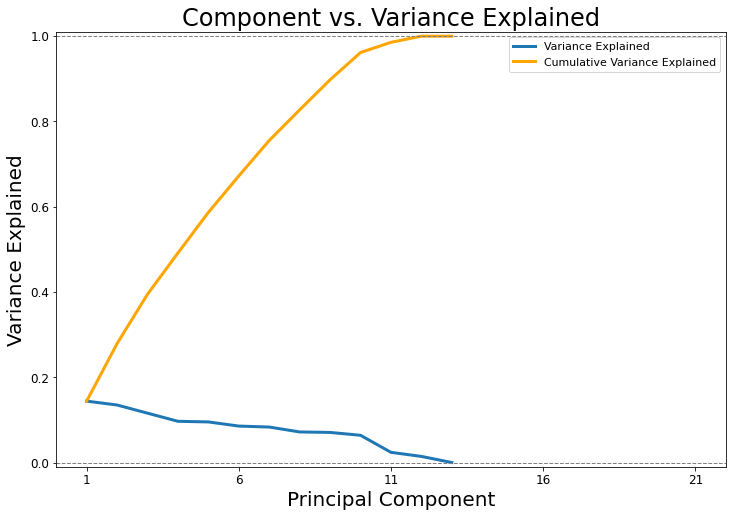

In [76]:
# Plot the variance explained (and cumulative variance explained).

# Set figure size.
plt.figure(figsize=(12,8))

# Plot the explained variance.
plt.plot(range(len(var_exp)), var_exp, lw=3, label = 'Variance Explained')

# Plot the cumulative explained variance.
plt.plot(range(len(var_exp)), cum_var_exp, lw=3, color = 'orange', label = 'Cumulative Variance Explained')


# Add horizontal lines at y=0 and y=1.
plt.axhline(y=0, linewidth=1, color='grey', ls='dashed')
plt.axhline(y=1, linewidth=1, color='grey', ls='dashed')

# Set the limits of the axes.
plt.xlim([-1,21])
plt.ylim([-0.01,1.01])

# Label the axes.
plt.ylabel('Variance Explained', fontsize=20)
plt.xlabel('Principal Component', fontsize=20)

# Make the tick labels bigger
plt.xticks(range(0, 21, 5), range(1, 22, 5), fontsize=12)
plt.yticks(fontsize=12)
    
# Add title and legend.
plt.title('Component vs. Variance Explained', fontsize=24)
plt.legend(fontsize=11);

In [77]:
# Instantiate PCA with 10 components.
pca = PCA(n_components = 10, random_state = 42)

# Fit PCA to training data.
pca.fit(X_train)

PCA(copy=True, iterated_power='auto', n_components=10, random_state=42,
    svd_solver='auto', tol=0.0, whiten=False)

In [78]:
# Instantiate linear regression model.
lm = LinearRegression()

# Transform Z_train and Z_test.
Z_train = pca.transform(X_train)
Z_test = pca.transform(X_test)

# Fit on Z_train.
lm.fit(Z_train, y_train)

# Score on training and testing sets.
print(f'Training Score: {round(lm.score(Z_train, y_train),4)}')
print(f'Testing Score: {round(lm.score(Z_test, y_test),4)}')

Training Score: 0.9841
Testing Score: -0.7437


In [80]:
X = price_df.drop(columns=['city/town', 'Scaled_Price'])
y = price_df['Scaled_Price']

# First, apply PCA
pca = PCA(svd_solver='auto', random_state=0)
X_pca = pca.fit_transform(scale(X))

In [81]:
n_component_list = range(1, 51)
r2_list = []
mse_list = []

# Second, Linear Regression
for i in n_component_list:
    lreg = LinearRegression()
    X_train, X_test, y_train, y_test = train_test_split(X_pca[:,:i], y, test_size=0.2, random_state=0)
    model = lreg.fit(X_train, y_train)
    # check the result
    y_pred = lreg.predict(X_test)
    r2 = r2_score(y_test, y_pred) # r2 score
    mse = mean_squared_error(y_test, y_pred) # mse
    r2_list.append(r2)
    mse_list.append(mse)
    
scores_df = pd.DataFrame.from_dict(dict([('NComponents', n_component_list),
                                        ('R2', r2_list),
                                        ('MSE', mse_list)]))
scores_df.set_index('NComponents', inplace=True)

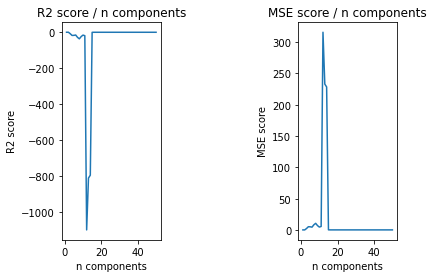

In [82]:
# plot the scores to see the best n_components
plt.subplot(1, 3, 1)
scores_df['R2'].plot(kind='line')
plt.title('R2 score / n components')
plt.ylabel('R2 score')
plt.xlabel('n components')

plt.subplot(1, 3, 3)
scores_df['MSE'].plot(kind='line')
plt.title('MSE score / n components')
plt.ylabel('MSE score')
plt.xlabel('n components')

plt.show()

In [83]:

r2_max = scores_df['R2'].idxmax()
print("Best n:", r2_max, "R2 score:", scores_df['R2'][r2_max])

mse_min = scores_df['MSE'].idxmin()
print("Best n:", mse_min, "MSE:", scores_df['MSE'][mse_min])

Best n: 2 R2 score: -0.7863564964192284
Best n: 2 MSE: 0.5121209651411087


In [84]:
# Use the best n_components parameter
lreg = LinearRegression()
X_train, X_test, y_train, y_test = train_test_split(X_pca[:,:r2_max], y, test_size=0.2, random_state=0)
model = lreg.fit(X_train, y_train)

# check the result
y_pred = lreg.predict(X_test)
r2 = r2_score(y_test, y_pred) # r2 score
mse = mean_squared_error(y_test, y_pred) # mse
print("R2 score:", r2)
print("MSE:", mse)

R2 score: -0.7863564964192284
MSE: 0.5121209651411087


In [85]:
# Let's try to project the coefs back to the original number of features
eigenvectors = pca.components_
pcr_coefs = eigenvectors[:r2_max, :].T @ lreg.coef_

pcr_coefs.shape

(229,)

In [86]:
# Let's check which venue types effect the most and least
print('\nMax positive coefs:', pcr_coefs[np.argsort(-pcr_coefs)[:10]])
print('\nVenue types with most positive effect:', X.columns[np.argsort(-pcr_coefs)[:10]].values)
print('\nMax negative coefs:', pcr_coefs[np.argsort(pcr_coefs)[:10]])
print('\nVenue types with most negative effect:', X.columns[np.argsort(pcr_coefs)[:10]].values)
coef_abs = abs(pcr_coefs)
print('\nMin coefs:', pcr_coefs[np.argsort(coef_abs)[:10]])
print('\nVenue types with least effect:', X.columns[np.argsort(coef_abs)[:10]].values)


Max positive coefs: [0.00470174 0.0040296  0.00399008 0.00367137 0.00367137 0.00367137
 0.00367137 0.00367137 0.00367137 0.00367137]

Venue types with most positive effect: ['Pool' 'Art Museum' 'Food Truck' 'Tennis Stadium' 'College Arts Building'
 'College Rec Center' 'Outdoor Sculpture' 'College Theater'
 'College Basketball Court' 'Garden']

Max negative coefs: [-0.00999989 -0.00996401 -0.00893257 -0.00882628 -0.00859115 -0.00836644
 -0.00805758 -0.00805758 -0.00792189 -0.00789238]

Venue types with most negative effect: ['Ice Cream Shop' 'Frozen Yogurt Shop' "Women's Store" 'Greek Restaurant'
 'New American Restaurant' 'Cosmetics Shop' 'Spanish Restaurant'
 'Toy / Game Store' 'Steakhouse' 'Kitchen Supply Store']

Min coefs: [ 1.44163280e-07  2.49355464e-05  3.66444045e-05  3.69791687e-05
  9.92373242e-05  1.04715148e-04  1.82251104e-04  1.82251104e-04
 -2.26877855e-04 -2.26877855e-04]

Venue types with least effect: ['Noodle House' 'Smoke Shop' 'Dim Sum Restaurant' 'Food' 'Bank'
 

## Clustering

In [ ]:
# set number of clusters
kclusters = 5

scc_grouped_clustering = df_grouped.drop('city/town', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(scc_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

In [ ]:
city_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

scc_merged = df

scc_merged = scc_merged.join(city_venues_sorted.set_index('city/town'), on='city/town')

scc_merged.head() 

In [ ]:
# Obtain coordinates for Santa Clara

address = 'Santa Clara, California'

geolocator = Nominatim(user_agent="http://nominatim.openstreetmap.org/reverse?email=jpander@gmail.com&format=xml&lat=-23.56320001&lon=-46.66140002&zoom=27&addressdetails=1")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Central Toronto are {}, {}.'.format(latitude, longitude))

In [ ]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=10)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(scc_merged['latitude'], scc_merged['longitude'], scc_merged['city/town'], scc_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow, #rainbow[cluster-1],
        fill=True,
        fill_color=rainbow, #rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

#### Cluster 1

In [ ]:
scc_merged.loc[scc_merged['Cluster Labels'] == 0, scc_merged.columns[[1] + list(range(5, scc_merged.shape[1]))]]

#### Cluster 2

In [ ]:
scc_merged.loc[scc_merged['Cluster Labels'] == 1, scc_merged.columns[[1] + list(range(5, scc_merged.shape[1]))]]

#### Cluster 3

In [ ]:
scc_merged.loc[scc_merged['Cluster Labels'] == 2, scc_merged.columns[[1] + list(range(5, scc_merged.shape[1]))]]

#### Cluster 4

In [ ]:
scc_merged.loc[scc_merged['Cluster Labels'] == 3, scc_merged.columns[[1] + list(range(5, scc_merged.shape[1]))]]

#### Cluster 5

In [ ]:
scc_merged.loc[scc_merged['Cluster Labels'] == 4, scc_merged.columns[[1] + list(range(5, scc_merged.shape[1]))]]